<a href="https://colab.research.google.com/github/leadeeerq/machine-learning/blob/main/PyTorch_Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

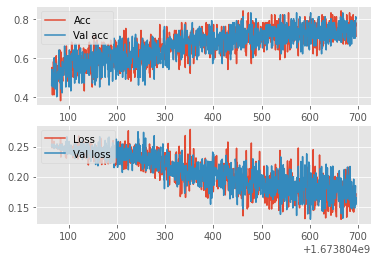

#Libraries

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

#Training data

In [ ]:
REBUILD_DATA = False

class DogsCats():
  IMG_SIZE = 50
  CATS = '/content/drive/MyDrive/Projekty Machine Learning/PyTorch/kagglecatsanddogs_5340/PetImages/Cat/'
  DOGS = '/content/drive/MyDrive/Projekty Machine Learning/PyTorch/kagglecatsanddogs_5340/PetImages/Dog/'
  LABELS = {CATS: 0, DOGS: 1}

  training_data = []
  catcount = 0
  dogcount = 0 

  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tqdm(os.listdir(label)):
        if "jpg" in f:
          try:
            path = os.path.join(label, f)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
            self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]], dtype=object)  # do something like print(np.eye(2)[1]), just makes one_hot 
            #print(np.eye(2)[self.LABELS[label]])

            if label == self.CATS:
              self.catcount += 1
            elif label == self.DOGS:
              self.dogcount += 1

          except Exception as e:
            pass
            #print(label, f, str(e))

    np.random.shuffle(self.training_data)
    np.save("training_data.npy", self.training_data)
    print('Cats:',dogsvcats.catcount)
    print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsCats()
    dogsvcats.make_training_data()

/content/drive/MyDrive/Projekty Machine Learning/PyTorch/kagglecatsanddogs_5340/PetImages/Cat/


100%|██████████| 12501/12501 [00:55<00:00, 225.66it/s]


/content/drive/MyDrive/Projekty Machine Learning/PyTorch/kagglecatsanddogs_5340/PetImages/Dog/


100%|██████████| 12501/12501 [00:57<00:00, 219.02it/s]
/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Cats: 12476
Dogs: 12470


In [ ]:
np.eye(2)[1]

array([0., 1.])

##Saving and loading the data

In [ ]:
training_data = np.load('training_data.npy', allow_pickle = True)

In [ ]:

type(training_data)

numpy.ndarray

In [ ]:
print(len(training_data))

24946


In [ ]:
with open('/content/drive/MyDrive/Projekty Machine Learning/PyTorch/training_data.pickle', 'wb') as handle:
    pickle.dump(training_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/Projekty Machine Learning/PyTorch/training_data.pickle', 'rb') as handle:
  training_data  = pickle.load(handle)
training_data = np.array(training_data)

##Plotting the data

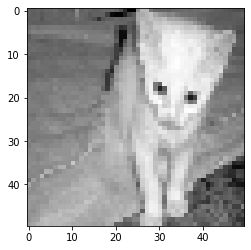

In [ ]:
plt.imshow(training_data[1][0], cmap = 'gray')
plt.show()

#Network model

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Convolutional 2 dimensional layers
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    #Dummy data to evaluate the "in_features" in fc1
    x = torch.randn(50, 50).view(-1, 1, 50, 50)

    #Set the flag to perform this only once
    self._to_linear = None
    self.convs(x)

    #Distribution of predicitons with linear layer
    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

    # print(x[0].shape)

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear) #Flatten layer
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim = 1)
    return x

net = Net()

#Optimizer

In [ ]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0 #Scaling the image to [0, 1]
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 #Validation set
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


<ipython-input-7-ca1463466822>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)


#Train test split

In [ ]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [ ]:
BATCH_SIZE = 64
EPOCHS = 5

def train(net):
  optimizer = optim.Adam(net.parameters(), lr = 0.001)
  loss_function = nn.MSELoss()

  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
      # print(i, i+BATCH_SIZE)
      batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
      batch_y = train_y[i:i+BATCH_SIZE]

      # Zeroing the gradient
      net.zero_grad()
      # optimizer.zero_grad()
      outputs = net(batch_X)
      loss = loss_function(outputs, batch_y)
      loss.backward()
      optimizer.step()

  print(loss)

#Evaluate the model

In [ ]:
def test(net):
  correct = 0
  total = 0
  with torch.no_grad():
    for i in tqdm(range(len(test_X))):
      real_class = torch.argmax(test_y[i])
      net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
      predicted_class = torch.argmax(net_out)
      if predicted_class == real_class:
        correct += 1
      total += 1
  print('Accuracy: ', round(correct/total, 3))

In [ ]:
test(net)

#Model analysis

In [ ]:
def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  accuracy = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return accuracy, loss

In [ ]:
def test(size = 32):
  random_start_pos = np.random.randint(len(test_X)- size)
  X, y = test_X[random_start_pos:random_start_pos+size], test_y[random_start_pos:random_start_pos+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50), y, train = False)

  return val_acc, val_loss

In [ ]:
val_acc, val_los = test(size = 200)
print(val_acc, val_los)

torch.Size([128, 2, 2])
0.685 tensor(0.2170)


#Visualizing the scores

In [ ]:
MODEL_NAME = f'model-{int(time.time())}'
net = Net()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
  BATCH_SIZE = 100
  EPOCHS = 5

  with open('/content/drive/MyDrive/Projekty Machine Learning/PyTorch/model.log', 'a') as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i: i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i: i+BATCH_SIZE]

        acc, loss = fwd_pass(batch_X, batch_y, train = True)
        if i % 50 == 0: #Every 50 steps perform the validation
          val_acc, val_loss = test(size = 100)
          f.write(f'{MODEL_NAME}, {round(time.time(),3)}, {round(float(acc),2)}, {round(float(loss),4)}, {round(float(val_acc),2)}, {round(float(val_loss),4)}\n')

train()

In [ ]:
model_name = 'model-1673804064'

def create_graph(model_name):
  contents = open('/content/drive/MyDrive/Projekty Machine Learning/PyTorch/model.log', 'r').read().split('\n')
  times = []
  accs = []
  losses = []
  val_accs = []
  val_losses = []

  for content in contents:
    if model_name in content:
      name, timestamp, acc, loss, val_acc, val_loss = content.split(',')
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))

  fig = plt.figure()
  ax1 = plt.subplot2grid((2,1), (0,0))
  ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)

  ax1.plot(times, accs, label = 'Acc')
  ax1.plot(times, val_accs, label = 'Val acc')
  ax1.legend(loc = 2)

  ax2.plot(times, losses, label = 'Loss')
  ax2.plot(times, val_losses, label = 'Val loss')
  ax2.legend(loc = 2)

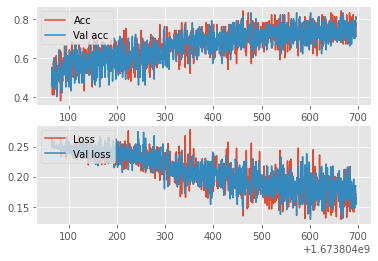

In [ ]:
create_graph('model-1673804064')